In [ ]:
# TODO Prediction selecting only True CryoSleep
# TODO Compare with prediction without splitting
# TODO Check EDA
# TODO Normalize plots by number of Transported True/False

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, mutual_info_regression, f_classif, mutual_info_classif
import sys

In [2]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import plot_density, plot_bars_target, na_plot, heatmap_triangle, heatmap_threshold, plot_stat_vs_mi_num, plot_stat_vs_mi_cat, plot_density_cat
from utilsStats import cramers_v, eta_squared

### Load data

In [3]:
# load data
df_train = pd.read_csv('data/train.csv')
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [4]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [8]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)

In [9]:
df_train_cstrue = df_train[df_train['CryoSleep'] == True]

### Feature 'Name'

There is no useful information in the passengers' names.

In [10]:
df_train_cstrue[['FirstName','Surname']] = df_train_cstrue['Name'].str.split(' ', expand = True)
print(f'Number of different surnames: {df_train_cstrue["Surname"].unique().shape[0]}')

Number of different surnames: 1583


/tmp/ipykernel_283954/1211949780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cstrue[['FirstName','Surname']] = df_train_cstrue['Name'].str.split(' ', expand = True)
/tmp/ipykernel_283954/1211949780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cstrue[['FirstName','Surname']] = df_train_cstrue['Name'].str.split(' ', expand = True)


### Feature exploration

#### Feature 'Num'

Num from 'Cabin' feature distribution
count    2953.000000
mean      574.367423
std       486.032922
min         0.000000
25%       159.000000
50%       395.000000
75%       959.000000
max      1888.000000
Name: Num, dtype: float64


/tmp/ipykernel_283954/2709732727.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cstrue['Num'] = df_train_cstrue['Num'].fillna(0)
/tmp/ipykernel_283954/2709732727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cstrue['Num'] = df_train_cstrue['Num'].astype(int)


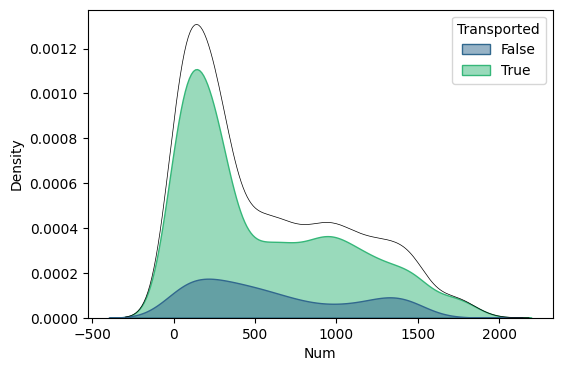

In [11]:
# distribution feature 'Num' 
print("Num from 'Cabin' feature distribution")
print(df_train_cstrue[~df_train_cstrue['Num'].isna()]['Num'].astype(int).describe())
# replace NA with 0
df_train_cstrue['Num'] = df_train_cstrue['Num'].fillna(0)
# convert to int keeping NAs
df_train_cstrue['Num'] = df_train_cstrue['Num'].astype(int)
plot_density_cat(df_train_cstrue, ['Num'], 'Transported',  1, 1)

#### Feature 'Age'

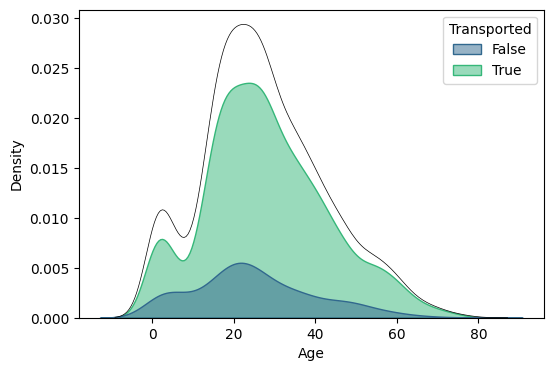

count    2955.000000
mean       27.405415
std        15.080469
min         0.000000
25%        18.000000
50%        26.000000
75%        37.000000
max        78.000000
Name: Age, dtype: float64


In [12]:
# visualize 'Age' feature
plot_density_cat(df_train_cstrue, ['Age'], 'Transported',  1, 1)
print(df_train_cstrue['Age'].describe())

#### Categorical features

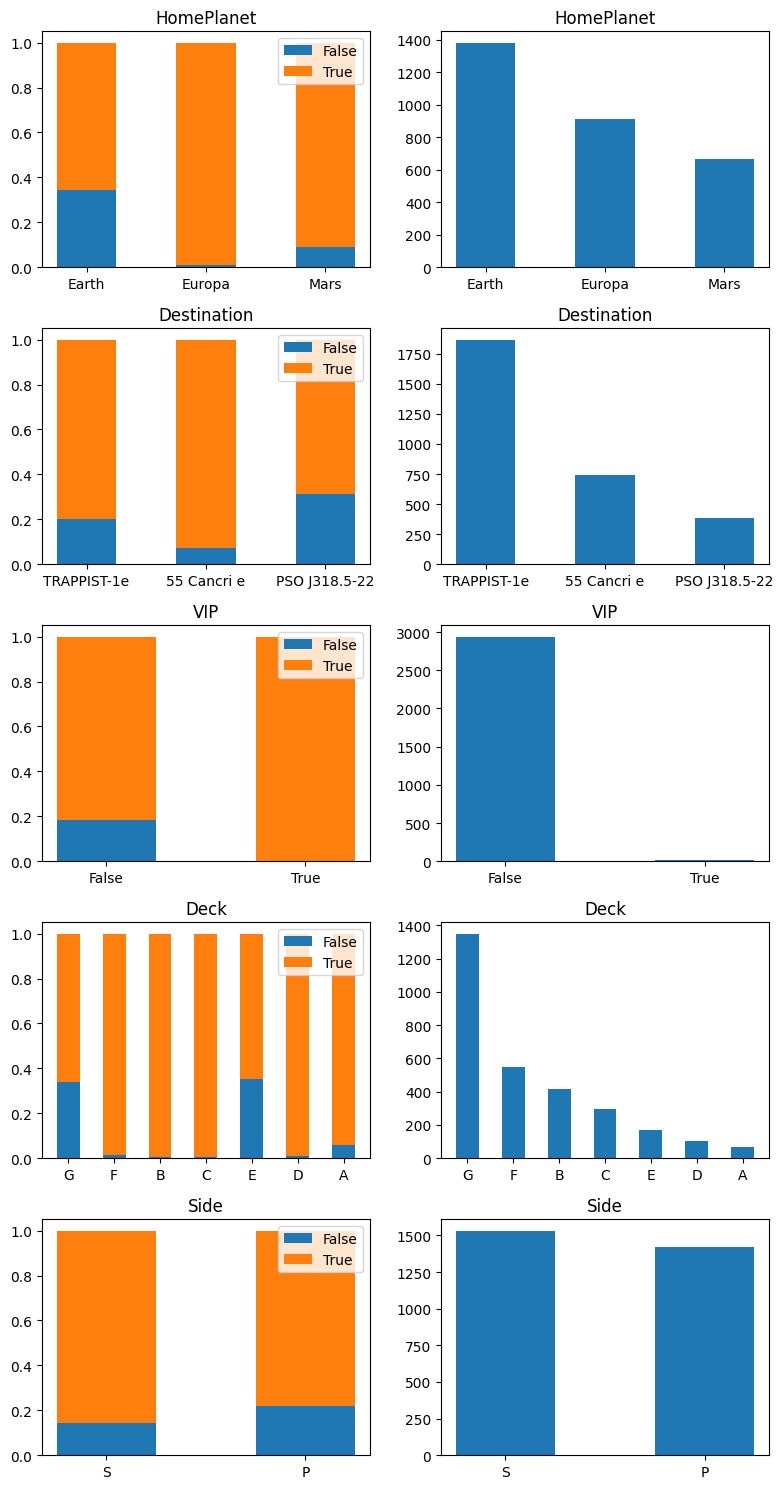

In [14]:
# visualize HomePlanet, CryoSleep, Destination, VIP
# TODO legend out of plot
cat_features = ['HomePlanet', 'Destination', 'VIP', 'Deck', 'Side']
plot_bars_target(df_train_cstrue, cat_features , 'Transported', sort = True)

### Correlation between explanatory features

#### Numerical features (Pearson correlation coeficient)

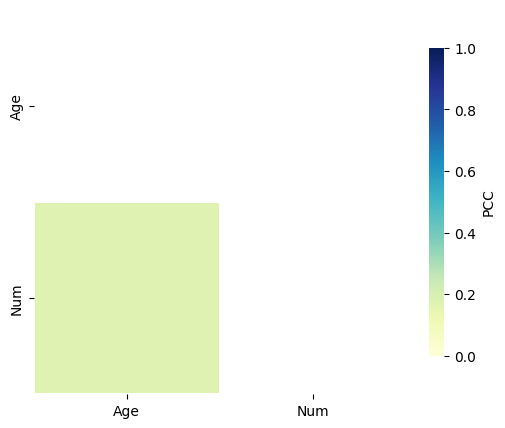

In [16]:
# correlation between quantitative features
selected_features = ['Age', 'Num']
df = df_train_cstrue[selected_features]
df = df.dropna()

# compute the correlation matrix
corr = np.abs(df.corr())

# plot heatmap
heatmap_triangle(corr, 'PCC')

#### Categorical features (Cramer's V test)

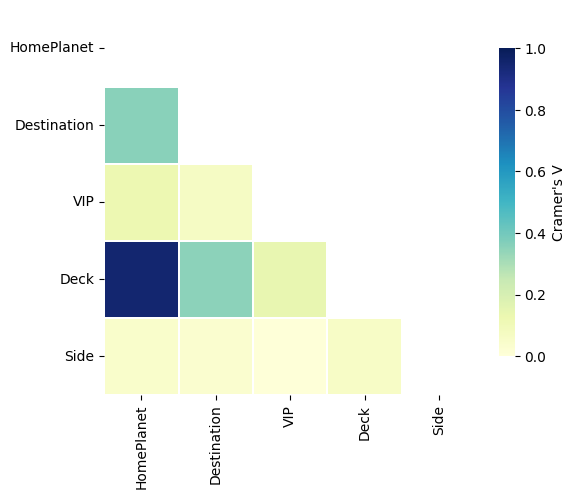

In [17]:
# relationship between categorical features (Cramer's V test)
categ_features= ['HomePlanet', 'Destination', 'VIP', 'Deck', 'Side'] #+ new_features

scores = []
for feature1 in categ_features:
    score_feature = []
    for feature2 in categ_features:
        score_feature.append(cramers_v(df_train_cstrue[feature1], df_train_cstrue[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = categ_features, index = categ_features)

heatmap_triangle(cramer, "Cramer's V")

#### Categorical vs Numeric features (Eta squared)

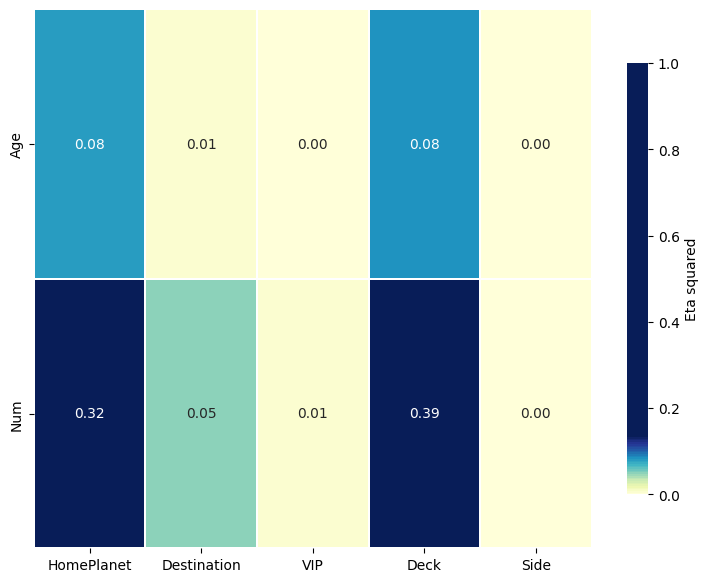

In [18]:
# relationship between quantitative vs qualitative features (Eta squared)
quant_features = ['Age', 'Num']

df = df_train_cstrue[categ_features + quant_features]
df = df.dropna()

scores = []
for qf in quant_features:
    score_feature = []
    for cf in categ_features:
        formula = f'{qf} ~ {cf}'
        score_feature.append(eta_squared(df, formula))
    scores.append(score_feature)

eta2 = pd.DataFrame(scores, columns = categ_features, index = quant_features)

heatmap_threshold(eta2, 0.14, 'Eta squared')

### Correlation between target and explanatory features

#### Numerical features

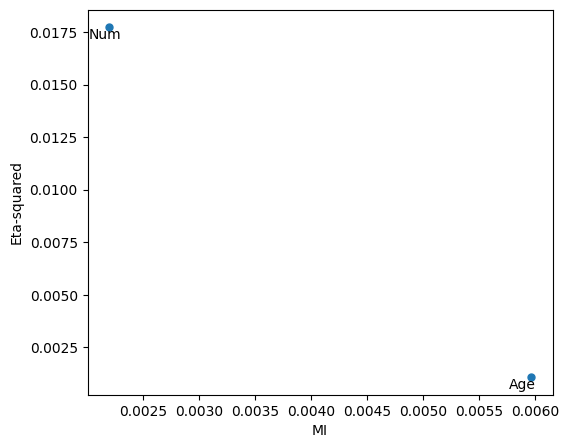

In [19]:
# relationship between quantitative features vs target (eta-squared/MI)

df = df_train_cstrue[quant_features + ['Transported']]
df = df.dropna()

X = df[quant_features]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features, 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

#### Categorical features

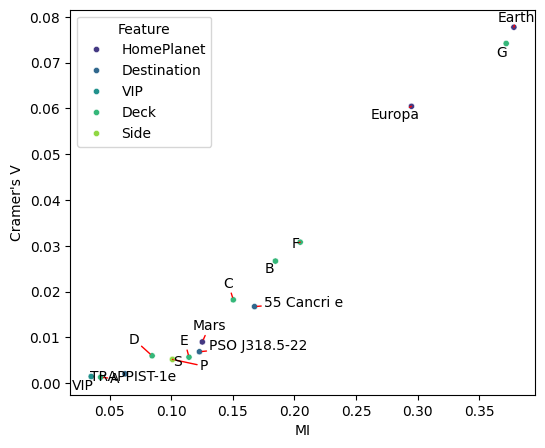

In [23]:
# relationship between categorical features vs target (Cramer's V test/MI)
# categ_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
TF_features = ['VIP'] # + new_features
drop_features = list(map(lambda x: f'{x}_False', TF_features))
df = df_train_cstrue[categ_features + ['Transported']].dropna()
# one-hot encode (required for scikit-learn)
#X_encoded = pd.get_dummies(df[categ_features]).drop(['VIP_False', 'CryoSleep_False'], axis=1)
X_encoded = pd.get_dummies(df[categ_features])
X_encoded = pd.get_dummies(df[categ_features]).drop(drop_features, axis=1)
y = df['Transported']

# calculate MI scores for feature selection
mi = mutual_info_classif(X_encoded, y, discrete_features=True) 

# calculate Cramer's V scores for feature selection
cramer = []
for cf in X_encoded.columns:
    cramer.append(cramers_v(X_encoded[cf], df['Transported']))

# build dataframe for plot
features_levels = list(map(lambda x: x.split('_'),X_encoded.columns))
features = list(map(lambda x: x[0], features_levels))
levels = list(map(lambda x: x[1], features_levels))
feature_stats = {'feature': features, 'level': levels, 'stat': cramer, 'mi': mi}

df = pd.DataFrame(feature_stats)
df['level'] = df.apply(lambda row: row['feature'] if row['level'] == 'True' else row['level'], axis=1)

plot_stat_vs_mi_cat(df, "Cramer's V")